# Model Building

I will now be testing the data on a comprehensive list of classifying models to determine which ones will be the most accurate in labeling the reddit posts.

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_colwidth = 200

In [2]:
# Reading in the saved CSV file

reddit = pd.read_csv('../datasets/reddit_slimmed.csv')
reddit.drop(columns='Unnamed: 0', inplace=True)
reddit.head()

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,ohio,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48
1,ohio,the chokehold jd vance has on my youtube ads.,"no matter how much you tell me about it, i’m not reading hillbilly elegy. but seriously, tim ryan needs to make an ad on there.",dreamsandboxes,9,25
2,ohio,need wedding photographer plzzz,hi everyone my fiancé and i booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . the past 2 weeks we have called then emailed even txted an...,ohiowelder,4,77
3,ohio,ranked choice voting?,"alaska seems to be doing well, when does ohio follow.",titanup1993,3,10
4,ohio,how long is the wait for a handgun purchased from atlantic gun &amp; tackle,not sure if this is the right place to be asking. but i recently just purchased a handgun from atlantic gun &amp; tackle and they said i could get approved today in the next hour or it could be up...,professional_pie4546,14,84


---

## Establishing the Baseline

In [3]:
reddit['subreddit_class'] = reddit['subreddit_class'].map({'ohio': 0, 'ihateohio': 1})

reddit.head(3)

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,0,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48
1,0,the chokehold jd vance has on my youtube ads.,"no matter how much you tell me about it, i’m not reading hillbilly elegy. but seriously, tim ryan needs to make an ad on there.",dreamsandboxes,9,25
2,0,need wedding photographer plzzz,hi everyone my fiancé and i booked a photographer last year for our wedding for 9/10/22 and we put a deposit down and signed a contract . the past 2 weeks we have called then emailed even txted an...,ohiowelder,4,77


In [4]:
X = reddit['title']
y = reddit['subreddit_class']

y.value_counts(normalize=True)

0    0.515508
1    0.484492
Name: subreddit_class, dtype: float64

This baseline is telling us that if we predicted that all posts were from the Ohio subreddit, we'd be correct 51.55% of the time.

I'll be running all models on both the selftext and title columns with minimal hyperparameters. This is because I want to evaluate the scores of the models alone and choose a handful of the top-performers to begin tuning with GridSearch until one becomes the clear champion.

Because sensitivity and specificity are not critically important in this case, I'll also be looking at the accuracy and misclassification rates for all models, and aiming to optimize for testing r2 scores (overall accuracy) when I begin running trials with hyperparameters included.

---

## Building a Function to Expedite Model Trials

Because I am going to be cycling through several different models in this next section, I think having a function to do most of the heavy lifting would streamline the process.

In [5]:
model_trials_df = pd.DataFrame(columns=['model_used', 'title_train_score', 'title_test_score',
'selftext_train_score', 'selftext_test_score'])

In [6]:
def model_trials(pipe, model_id):

    '''Setting X and y to first use the title column as the predictor'''
    X_t = reddit['title']
    y_t = reddit['subreddit_class']
    X_train, X_test_t, y_train, y_test_t = train_test_split(X_t, y_t, test_size=0.2, stratify=y_t, random_state=42)
    pipe.fit(X_train, y_train)
    t_train_score = pipe.score(X_train, y_train)
    t_test_score = pipe.score(X_test_t, y_test_t)

    '''Calculating accuracy and misclassification rates for title'''
    t_preds = pipe.predict(X_test_t)
    tn, fp, fn, tp = confusion_matrix(y_test_t, t_preds).ravel()
    t_acc = (tp + tn) / (tn + fp + tp + fn)
    t_misclass = 1 - t_acc

    '''Now redefining X and y to analyze the selftext column'''
    X_st = reddit['selftext']
    y_st = reddit['subreddit_class']
    X_train, X_test_st, y_train, y_test_st = train_test_split(X_st, y_st, test_size=0.2, stratify=y_t, random_state=42)
    pipe.fit(X_train, y_train)
    st_train_score = pipe.score(X_train, y_train)
    st_test_score = pipe.score(X_test_st, y_test_st)

    '''Calculating accuracy and misclassification rates for selftext'''
    st_preds = pipe.predict(X_test_st)
    tn, fp, fn, tp = confusion_matrix(y_test_st, st_preds).ravel()
    st_acc = (tp + tn) / (tn + fp + tp + fn)
    st_misclass = 1 - st_acc

    '''Adding the two scores for both Xs to the model_trials dataframe'''
    model_list = [model_id, t_train_score, t_test_score, st_train_score, st_test_score]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show me all scores to see how they compare to each other'''
    print(f'Title {model_id} Training Score: {round(t_train_score, 5)}')
    print(f'Title {model_id} Testing Score: {round(t_test_score, 5)} \n')
    print(f'Selftext {model_id} Training Score: {round(st_train_score, 5)}')
    print(f'Selftext {model_id} Testing Score: {round(st_test_score, 5)} \n')
    print(f'Title Accuracy Rate: {round(t_acc, 5)}')
    print(f'Title Misclassification Rate: {round(t_misclass, 5)} \n')
    print(f'Selftext Accuracy Rate: {round(st_acc, 5)}')
    print(f'Selftext Misclassification Rate: {round(st_misclass, 5)} \n')

    '''Returning a confusion matrix for the predictor that had the highest accuracy'''
    print('Best accuracy rate confusion matrix:')
    if t_acc > st_acc:
        return plot_confusion_matrix(pipe, X_test_t, y_test_t, cmap='YlOrRd', values_format='d');
    else: 
        return plot_confusion_matrix(pipe, X_test_st, y_test_st, cmap='YlGnBu', values_format='d');

In each section, I'll define the pipeline I want to use, but the function should do the rest and spit out each of the training and testing scores for title and selftext. It will also append the scores to the overall dataframe that I'll be using after to decide which models to move forward with.

---

## Logistic Regression

In [7]:
cvec_lr = Pipeline([
        ('cvec', CountVectorizer()),
        ('lr', LogisticRegression(max_iter=200, solver='saga', random_state=42))
])

Title CVec Logistic Regression Training Score: 0.95655
Title CVec Logistic Regression Testing Score: 0.75668 

Selftext CVec Logistic Regression Training Score: 0.85495
Selftext CVec Logistic Regression Testing Score: 0.86364 

Title Accuracy Rate: 0.75668
Title Misclassification Rate: 0.24332 

Selftext Accuracy Rate: 0.86364
Selftext Misclassification Rate: 0.13636 

Best accuracy rate confusion matrix:


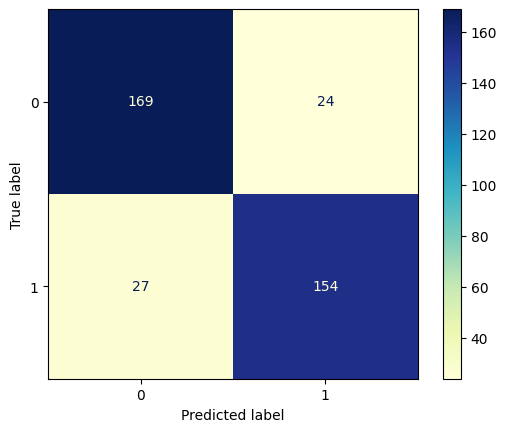

In [8]:
model_trials(cvec_lr, 'CVec Logistic Regression')

I'm curious to see if using the Tfidf Vectorizer would have any effect on any of the scores. Creating a new pipeline below that is exactly the same as above, with only the CountVectorizer edited. 

In [9]:
tfvec_lr = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('lr', LogisticRegression(max_iter=200, solver='saga', random_state=42))
])

Title TfVec Logistic Regression Training Score: 0.92045
Title TfVec Logistic Regression Testing Score: 0.73262 

Selftext TfVec Logistic Regression Training Score: 0.87166
Selftext TfVec Logistic Regression Testing Score: 0.84759 

Title Accuracy Rate: 0.73262
Title Misclassification Rate: 0.26738 

Selftext Accuracy Rate: 0.84759
Selftext Misclassification Rate: 0.15241 

Best accuracy rate confusion matrix:


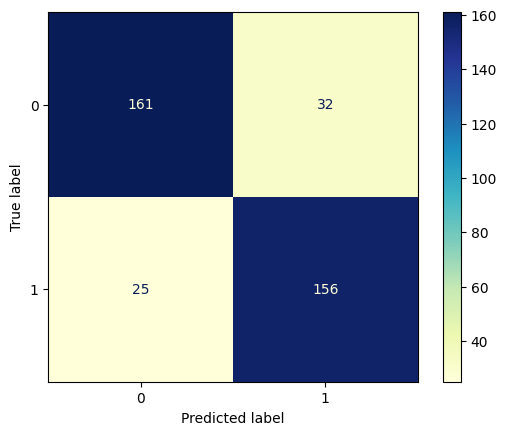

In [10]:
model_trials(tfvec_lr, 'TfVec Logistic Regression')

In [11]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.956551,0.756684,0.854947,0.863636
1,TfVec Logistic Regression,0.920455,0.732620,0.871658,0.847594


### Analysis

These are both fairly solid starting models - although the title scores have quite a bit more variance than the selftext scores.

When we used Tfidf in place of CountVectorizer, both title scores decreased as well as the selftext test score. The only improvement seen was in the selftext train score.

In both test cases, the Logisitic Regression pipeline that used selftext as the feature performed better than the models that used the title as their independent variable. This may be because there are more definitive (easier to classify) words in the selftext/caption area of posts.

Because I believe that score differences may depend on the model/transformer combination used, I'll be running all with both CountVectorizer and TfidfVectorizer moving forward.

---

## Multinomial Naive Bayes

In [12]:
cvec_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

Title CVec Mn Naive Bayes Training Score: 0.94786
Title CVec Mn Naive Bayes Testing Score: 0.74332 

Selftext CVec Mn Naive Bayes Training Score: 0.59626
Selftext CVec Mn Naive Bayes Testing Score: 0.52674 

Title Accuracy Rate: 0.74332
Title Misclassification Rate: 0.25668 

Selftext Accuracy Rate: 0.52674
Selftext Misclassification Rate: 0.47326 

Best accuracy rate confusion matrix:


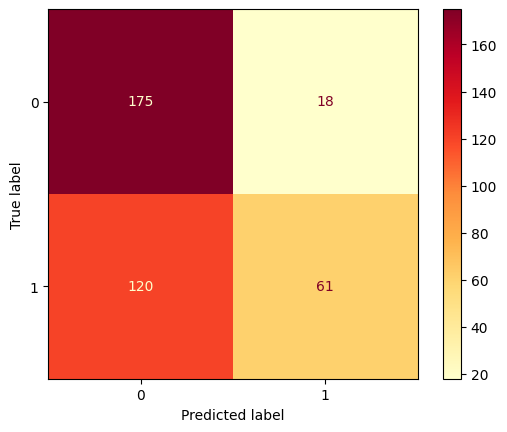

In [13]:
model_trials(cvec_mnb, 'CVec Mn Naive Bayes')

In [14]:
tfvec_mnb = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

Title TfVec Mn Naive Bayes Training Score: 0.9492
Title TfVec Mn Naive Bayes Testing Score: 0.74064 

Selftext TfVec Mn Naive Bayes Training Score: 0.55882
Selftext TfVec Mn Naive Bayes Testing Score: 0.52941 

Title Accuracy Rate: 0.74064
Title Misclassification Rate: 0.25936 

Selftext Accuracy Rate: 0.52941
Selftext Misclassification Rate: 0.47059 

Best accuracy rate confusion matrix:


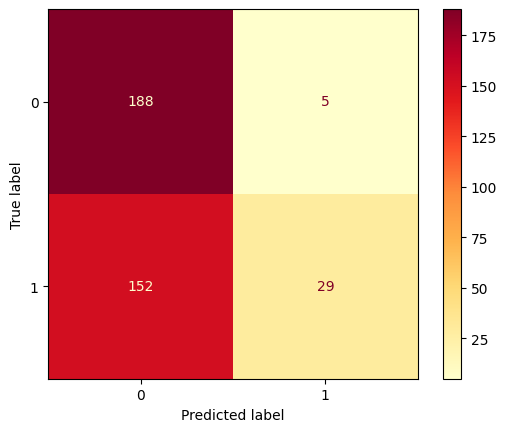

In [15]:
model_trials(tfvec_mnb, 'TfVec Mn Naive Bayes')

In [16]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.956551,0.756684,0.854947,0.863636
1,TfVec Logistic Regression,0.920455,0.732620,0.871658,0.847594
2,CVec Mn Naive Bayes,0.947861,0.743316,0.596257,0.526738
3,TfVec Mn Naive Bayes,0.949198,0.740642,0.558824,0.529412


### Analysis

The Multinomial Naive Bayes model performed significantly worse than the Logistic Regression model on the selftext feature, and about the same on the title feature. 

Based on the confusion matrix above, we see a large majority of true negatives and false negatives (both of these metrics increased when using Tdidf), meaning that the model classified most posts as being from the 'Ohio' subreddit, and very few as being from 'IHateOhio'. 

I'm guessing it could be related to the zero observation problem; according to [this site](https://www.baeldung.com/cs/naive-bayes-classification-performance), if the model 'comes across a feature that isn't present in the training set, the probability of 0 is automatically assigned.' Given this, it may explain why we see a much heavier '0' predicted label, and/or a lot of the content between the two subreddits is more similar than different.

---

## KNN Classifier

In [17]:
cvec_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

Title CVec KNN Training Score: 0.64505
Title CVec KNN Testing Score: 0.53743 

Selftext CVec KNN Training Score: 0.54278
Selftext CVec KNN Testing Score: 0.51337 

Title Accuracy Rate: 0.53743
Title Misclassification Rate: 0.46257 

Selftext Accuracy Rate: 0.51337
Selftext Misclassification Rate: 0.48663 

Best accuracy rate confusion matrix:


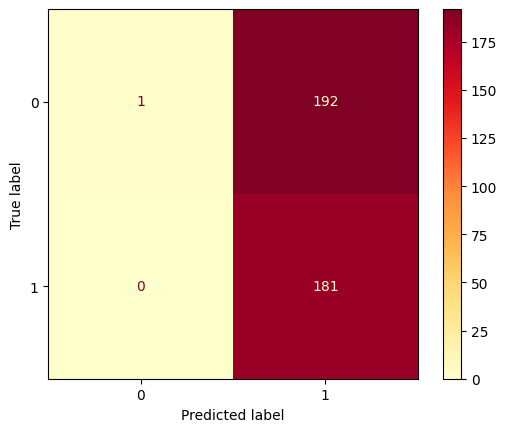

In [18]:
model_trials(cvec_knn, 'CVec KNN')

In [19]:
tfvec_knn = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

Title TfVec KNN Training Score: 0.63302
Title TfVec KNN Testing Score: 0.54545 

Selftext TfVec KNN Training Score: 0.49198
Selftext TfVec KNN Testing Score: 0.48396 

Title Accuracy Rate: 0.54545
Title Misclassification Rate: 0.45455 

Selftext Accuracy Rate: 0.48396
Selftext Misclassification Rate: 0.51604 

Best accuracy rate confusion matrix:


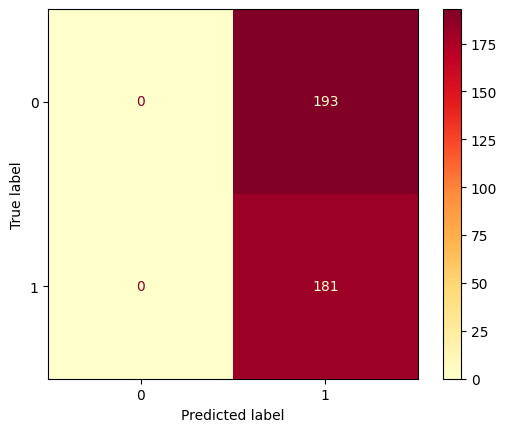

In [20]:
model_trials(tfvec_knn, 'TfVec KNN')

### Analysis

The KNN model performed about as well as the baseline score, and classified in a similar way.

In the model that used CountVectorizer, all but one post were predicted as being from the IHateOhio subreddit. When we switched to Tfidf, the model classified all posts as being from the IHateOhio subreddit.

I do think that the hyperparameters could be adjusted to likely produce a higher score, but given these scores as the baseline, KNN seems unlikely to outperform the Logistic Regression model or any others.

Introducing randomness into the model is needed to decrease the variance.

---

## Decision Tree Classifier

In [21]:
cvec_dtree = Pipeline([
        ('cvec', CountVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

Title CVec Decision Tree Training Score: 0.99599
Title CVec Decision Tree Testing Score: 0.68449 

Selftext CVec Decision Tree Training Score: 0.92848
Selftext CVec Decision Tree Testing Score: 0.85027 

Title Accuracy Rate: 0.68449
Title Misclassification Rate: 0.31551 

Selftext Accuracy Rate: 0.85027
Selftext Misclassification Rate: 0.14973 

Best accuracy rate confusion matrix:


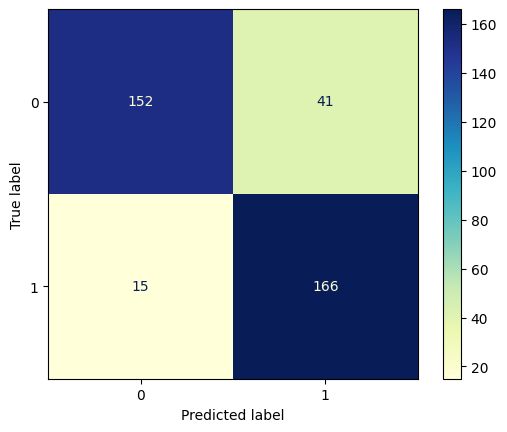

In [22]:
model_trials(cvec_dtree, 'CVec Decision Tree')

In [23]:
tvec_dtree = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

Title TfVec Decision Tree Training Score: 0.99599
Title TfVec Decision Tree Testing Score: 0.64439 

Selftext TfVec Decision Tree Training Score: 0.92848
Selftext TfVec Decision Tree Testing Score: 0.81283 

Title Accuracy Rate: 0.64439
Title Misclassification Rate: 0.35561 

Selftext Accuracy Rate: 0.81283
Selftext Misclassification Rate: 0.18717 

Best accuracy rate confusion matrix:


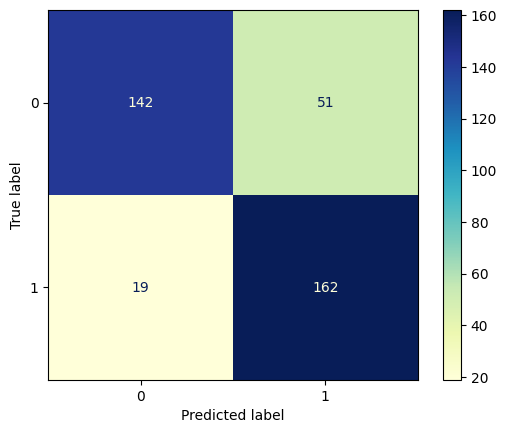

In [24]:
model_trials(tvec_dtree, 'TfVec Decision Tree')

In [25]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.956551,0.756684,0.854947,0.863636
1,TfVec Logistic Regression,0.920455,0.732620,0.871658,0.847594
2,CVec Mn Naive Bayes,0.947861,0.743316,0.596257,0.526738
3,TfVec Mn Naive Bayes,0.949198,0.740642,0.558824,0.529412
4,CVec KNN,0.645053,0.537433,0.542781,0.513369
5,TfVec KNN,0.633021,0.545455,0.491979,0.483957
6,CVec Decision Tree,0.995989,0.684492,0.928476,0.850267
7,TfVec Decision Tree,0.995989,0.644385,0.928476,0.812834


### Analysis

For both title and selftext, the train scores remained exactly the same using CountVectorizer and TfidfVectorizer. We saw parallel effects on the test scores also, with both decreasing by about .04 when using Tfidf instead of CVec.

We are overfit on both Decision Tree (and most other model) train/test splits, but the selftext scores are relatively high, making this model strong enough to move forward with and see if we can bring down the variance by adjusting the hyperparameters.

---

## Random Forest Classifier

In [26]:
cvec_rf = Pipeline([
        ('cvec', CountVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
])

Title CVec Random Forest Training Score: 0.99599
Title CVec Random Forest Testing Score: 0.75401 

Selftext CVec Random Forest Training Score: 0.92848
Selftext CVec Random Forest Testing Score: 0.84492 

Title Accuracy Rate: 0.75401
Title Misclassification Rate: 0.24599 

Selftext Accuracy Rate: 0.84492
Selftext Misclassification Rate: 0.15508 

Best accuracy rate confusion matrix:


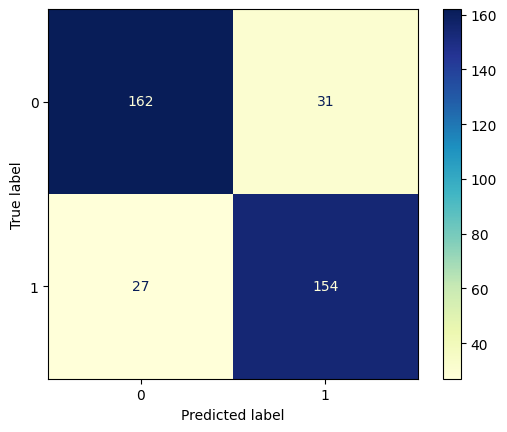

In [27]:
model_trials(cvec_rf, 'CVec Random Forest')

In [28]:
tfvec_rf = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
])

Title TfVec Random Forest Training Score: 0.99599
Title TfVec Random Forest Testing Score: 0.72727 

Selftext TfVec Random Forest Training Score: 0.92848
Selftext TfVec Random Forest Testing Score: 0.83957 

Title Accuracy Rate: 0.72727
Title Misclassification Rate: 0.27273 

Selftext Accuracy Rate: 0.83957
Selftext Misclassification Rate: 0.16043 

Best accuracy rate confusion matrix:


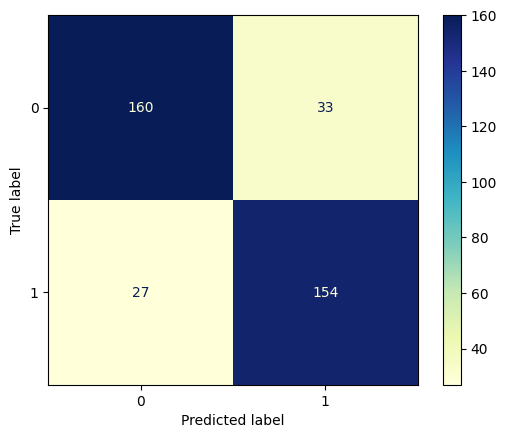

In [29]:
model_trials(tfvec_rf, 'TfVec Random Forest')

### Analysis

Using Tfidf looks to have reclassified two of the true negatives as false positives. Otherwise, both models performed very well and had .8+ accuracy rates.

What's more interesting is that the title and selftext train scores for the Decision Tree model (0.995989 and 0.928476, respectively) are exactly the same as the scores seen in the Random Forest model. Switching from Count Vectorizer to Tfidf did not seem to have any effect, either.

Looking at the confusion matrices for these four models, which were generated from the X variable that produced the greatest test score (selftext, in all cases here), we can see that the predictions are almost the inverses of each other. Both Decision Tree models made more classifications--56%, on average--in the IHateOhio subreddit, leading to more true and false positives. 

Conversely, the Random Forest models had similar misclassification rates, but leaned more heavily toward Ohio subreddit predictions. This could mean that this is a better model, or that it performed well in part because it made more predictions of the majority class. In all, the top test-scoring model of the four was the CountVectorizer Decision Tree.

Except for KNN and Multinomial Naive Bayes, all other confusion matrices have a similar pattern and there seem to be roughly 55-65 posts that are difficult for most models to classify. This is something I'll want to look into as it may be an indication of something I missed during EDA.

---

## Bagging Classifier

In [30]:
bag_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(random_state=42))
])

Title CVec Bagging Training Score: 0.97861
Title CVec Bagging Testing Score: 0.7139 

Selftext CVec Bagging Training Score: 0.91243
Selftext CVec Bagging Testing Score: 0.85829 

Title Accuracy Rate: 0.7139
Title Misclassification Rate: 0.2861 

Selftext Accuracy Rate: 0.85829
Selftext Misclassification Rate: 0.14171 

Best accuracy rate confusion matrix:


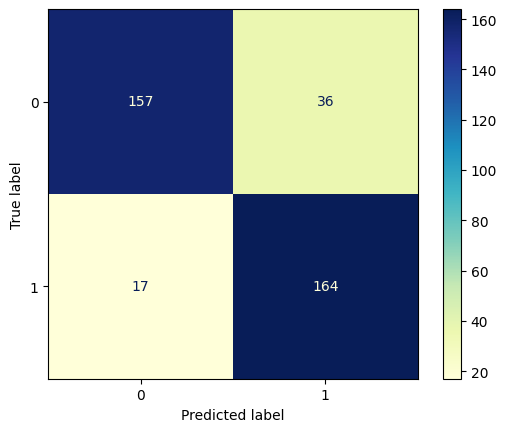

In [31]:
model_trials(bag_pipe, 'CVec Bagging')

In [32]:
tfvec_bag_pipe = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('bag', BaggingClassifier(random_state=42))
])

Title TfVec Bagging Training Score: 0.98396
Title TfVec Bagging Testing Score: 0.70053 

Selftext TfVec Bagging Training Score: 0.9131
Selftext TfVec Bagging Testing Score: 0.85294 

Title Accuracy Rate: 0.70053
Title Misclassification Rate: 0.29947 

Selftext Accuracy Rate: 0.85294
Selftext Misclassification Rate: 0.14706 

Best accuracy rate confusion matrix:


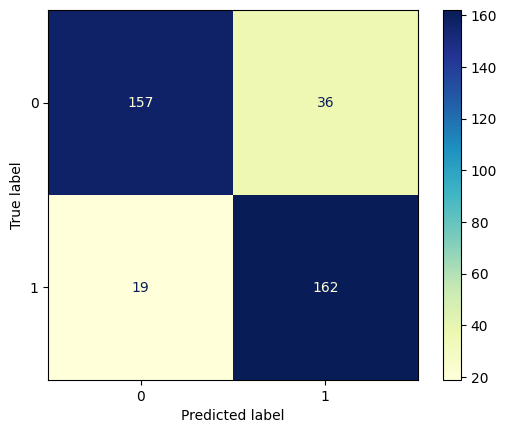

In [33]:
model_trials(tfvec_bag_pipe, 'TfVec Bagging')

### Analysis

Again, using Tfidf led to minimal shifts in classifications, this time with two true positive posts being reclassified as false negatives.

The Bagging model performed slightly better on the selftext test scores, but worse on most other scores. All train and test scores are very similar to those seen in the Decision Tree and Random Forest models, only with less variance because the trees are being exposed to different samples of the training set.

We can see below that the Logistic Regression model and the Bagging model have the exact same average (between CVec and TfVec) test scores when using selftext as X, despite making different predictions.

In [34]:
logreg_selftext_test_avg = (model_trials_df['selftext_test_score'][0] + model_trials_df['selftext_test_score'][1]) / 2

bagging_selftext_test_avg = (model_trials_df['selftext_test_score'][10] + model_trials_df['selftext_test_score'][11]) / 2

print(f'Logistic Regression Selftext Test Avg: {logreg_selftext_test_avg}')
print(f'Bagging Selftext Test Avg: {bagging_selftext_test_avg}')

Logistic Regression Selftext Test Avg: 0.8556149732620321
Bagging Selftext Test Avg: 0.8556149732620321


In [35]:
model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.956551,0.756684,0.854947,0.863636
1,TfVec Logistic Regression,0.920455,0.732620,0.871658,0.847594
2,CVec Mn Naive Bayes,0.947861,0.743316,0.596257,0.526738
3,TfVec Mn Naive Bayes,0.949198,0.740642,0.558824,0.529412
4,CVec KNN,0.645053,0.537433,0.542781,0.513369
5,TfVec KNN,0.633021,0.545455,0.491979,0.483957
6,CVec Decision Tree,0.995989,0.684492,0.928476,0.850267
7,TfVec Decision Tree,0.995989,0.644385,0.928476,0.812834
8,CVec Random Forest,0.995989,0.754011,0.928476,0.844920
9,TfVec Random Forest,0.995989,0.727273,0.928476,0.839572


---

## AdaBoost Classifier

In [36]:
cvec_ada = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(random_state=42))
])

Title CVec AdaBoosting Training Score: 0.75
Title CVec AdaBoosting Testing Score: 0.67112 

Selftext CVec AdaBoosting Training Score: 0.86297
Selftext CVec AdaBoosting Testing Score: 0.85561 

Title Accuracy Rate: 0.67112
Title Misclassification Rate: 0.32888 

Selftext Accuracy Rate: 0.85561
Selftext Misclassification Rate: 0.14439 

Best accuracy rate confusion matrix:


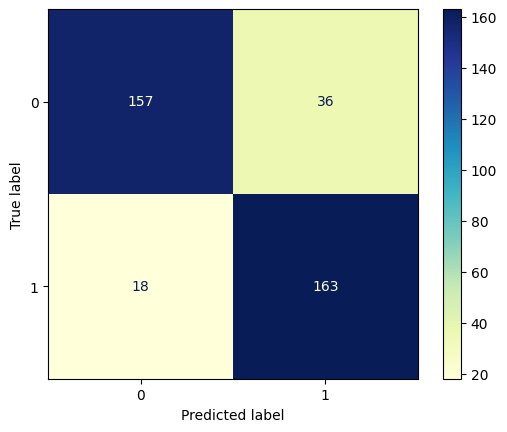

In [37]:
model_trials(cvec_ada, 'CVec AdaBoosting')

In [38]:
tfvec_ada = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(random_state=42))
])

Title TfVec AdaBoosting Training Score: 0.76471
Title TfVec AdaBoosting Testing Score: 0.68182 

Selftext TfVec AdaBoosting Training Score: 0.88168
Selftext TfVec AdaBoosting Testing Score: 0.84759 

Title Accuracy Rate: 0.68182
Title Misclassification Rate: 0.31818 

Selftext Accuracy Rate: 0.84759
Selftext Misclassification Rate: 0.15241 

Best accuracy rate confusion matrix:


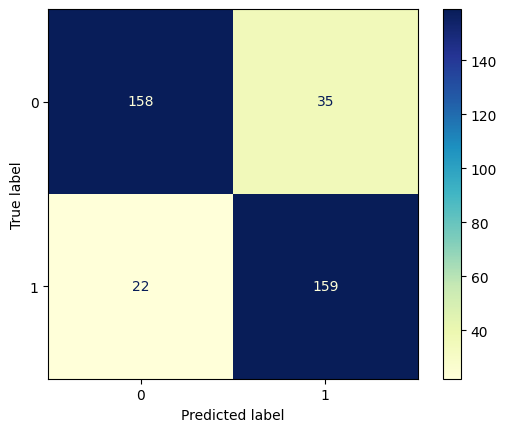

In [39]:
model_trials(tfvec_ada, 'TfVec AdaBoosting')

### Analysis

In terms of the test scores, AdaBoosting appears to be less effective in this dataset than Bagging. 

Using TfVec in the AdaBoost model increased both title scores and the selftext train score, but decreased the selftext test score. It looks like five posts were reclassified, one correctly and four incorrectly. 

Although these are not the best-scoring models, there does seem to be significantly less variance in the selftext scores than most of the other models. I'm going to try using this same model, but with Logistic Regression as the base estimator because LogReg is one of the other better-performing models we've seen so far.

---

## AdaBoost Classifier with Logistic Regression

In [40]:
cvec_ada_logreg = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42))
])

Title CVec AdaBoosting w/ LogReg Training Score: 0.73329
Title CVec AdaBoosting w/ LogReg Testing Score: 0.70588 

Selftext CVec AdaBoosting w/ LogReg Training Score: 0.86765
Selftext CVec AdaBoosting w/ LogReg Testing Score: 0.83155 

Title Accuracy Rate: 0.70588
Title Misclassification Rate: 0.29412 

Selftext Accuracy Rate: 0.83155
Selftext Misclassification Rate: 0.16845 

Best accuracy rate confusion matrix:


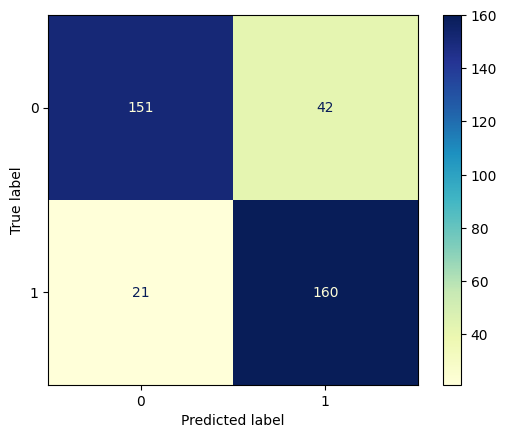

In [41]:
model_trials(cvec_ada_logreg, 'CVec AdaBoosting w/ LogReg')

In [42]:
tfvec_ada_logreg = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42))
])

Title TfVec AdaBoosting w/ LogReg Training Score: 0.68516
Title TfVec AdaBoosting w/ LogReg Testing Score: 0.67914 

Selftext TfVec AdaBoosting w/ LogReg Training Score: 0.81417
Selftext TfVec AdaBoosting w/ LogReg Testing Score: 0.8369 

Title Accuracy Rate: 0.67914
Title Misclassification Rate: 0.32086 

Selftext Accuracy Rate: 0.8369
Selftext Misclassification Rate: 0.1631 

Best accuracy rate confusion matrix:


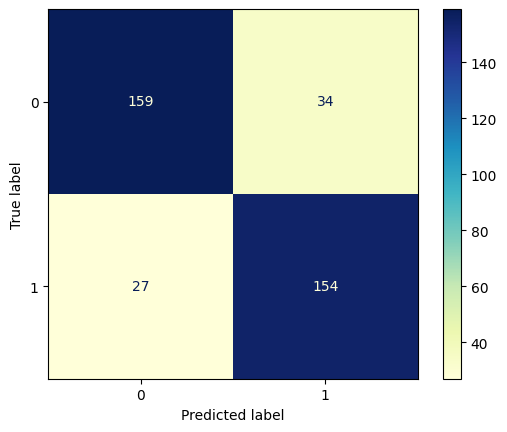

In [43]:
model_trials(tfvec_ada_logreg, 'TfVec AdaBoosting w/ LogReg')

### Analysis

Again, we see the differences between the CountVectorizer and Tfidf interpretations of the text. In this case, CountVectorizer made more predictions for the IHateOhio class and Tfidf was almost split down the middle, with 186 negative predictions (85% were correct) and 188 positive predictions (82% were correct). 

Contrary to my prior hypothesis, using Logistic Regression in conjunction with AdaBoost did not improve the test scores for title or selftext. That being said, these models did still perform relatively well and may be worth exploring further, with hyperparameter tuning.

---

## Gradient Boosting Classifier

In [44]:
cvec_gboost = Pipeline([
    ('cvec', CountVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

Title CVec Gradient Boosting Training Score: 0.79947
Title CVec Gradient Boosting Testing Score: 0.68984 

Selftext CVec Gradient Boosting Training Score: 0.87834
Selftext CVec Gradient Boosting Testing Score: 0.85829 

Title Accuracy Rate: 0.68984
Title Misclassification Rate: 0.31016 

Selftext Accuracy Rate: 0.85829
Selftext Misclassification Rate: 0.14171 

Best accuracy rate confusion matrix:


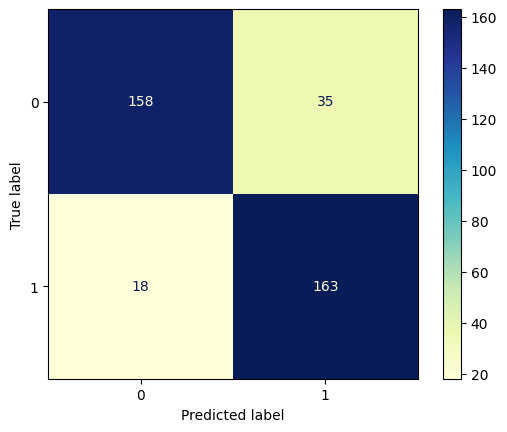

In [45]:
model_trials(cvec_gboost, 'CVec Gradient Boosting')

In [46]:
tfvec_gboost = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

Title TfVec Gradient Boosting Training Score: 0.82219
Title TfVec Gradient Boosting Testing Score: 0.70588 

Selftext TfVec Gradient Boosting Training Score: 0.89773
Selftext TfVec Gradient Boosting Testing Score: 0.86096 

Title Accuracy Rate: 0.70588
Title Misclassification Rate: 0.29412 

Selftext Accuracy Rate: 0.86096
Selftext Misclassification Rate: 0.13904 

Best accuracy rate confusion matrix:


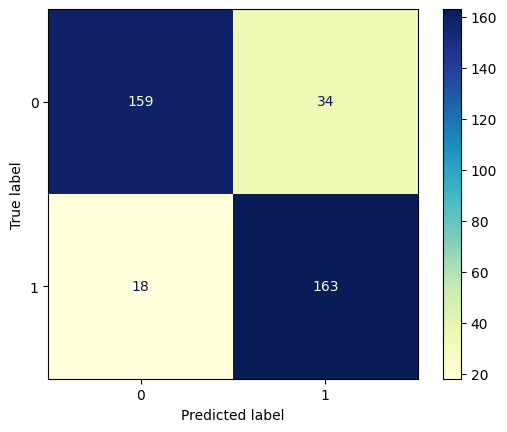

In [47]:
model_trials(tfvec_gboost, 'TfVec Gradient Boosting')

### Analysis

GradientBoosting is one of the best performing models yet in terms of average selftext test score, and to my surprise, outperformed AdaBoost. Though GBoost did have more false positives than a few other models, it also had some of the lowest false negative predictions. Using Tfidf here looks to have reclassified one false positive as a true negative while all else stayed the same. 

This model scored slightly worse than Bagging on title train and test scores, and the selftext train score. However, the selftext test score jumped by about .02, making GBoost a strong contender for the next level of model trials and adaptations.

---

## Which posts are continuously being misclassified?

In the above matrices, we see a lot of similar patterns, which I think could mean that there is a specific subset of post selftexts that most models are unable to accurately classify.

I'll select a few of the most similar distributions to check for repeated misclassifications.

In [48]:
misclassify_df = pd.DataFrame()

In [49]:
def misclassify(model):
    X = reddit['selftext']
    y = reddit['subreddit_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    true = y_test

    sub_df = pd.DataFrame()
    sub_df['post_text'] = X_test
    sub_df['preds'] = preds
    sub_df['true'] = true

    sub_df = sub_df[sub_df['preds'] != sub_df['true']]

    new_df = pd.concat([misclassify_df, sub_df])

    print(f'This model had {len(sub_df)} misclassifications.')
    return new_df

In [50]:
misclassify(tfvec_gboost)

This model had 52 misclassifications.


,post_text,preds,true
20,,1,0
992,[https://energynews.us/2022/04/18/dark-money-helped-ohio-utilities-subsidize-coal-plants-delaying-action-on-climate-change-at-ratepayers-expense/](https://energynews.us/2022/04/18/dark-money-helpe...,0,1
372,,1,0
805,is michigan r bitch now i’m college fb,1,0
1199,[https://www.nbcnews.com/news/us-news/frantic-parents-fear-kids-after-radioactive-contamination-found-ohio-middle-n1005771](https://www.nbcnews.com/news/us-news/frantic-parents-fear-kids-after-ra...,0,1
1233,"hey guys. just wanna keep spreading the hate for that god awful state. i promise to run for president one day, and with my first act, issue an executive order. either separating ohio from the unit...",0,1
308,popular vote,1,0
1005,for reference i work for um and gave my mother in law a maze and blue winter jacket. she still lives in ohio because we haven't been able to find her a suitable place near us in michigan. she walk...,0,1
600,,1,0
492,,1,0


In [51]:
misclassify_df = pd.concat([misclassify(tfvec_gboost), misclassify(cvec_ada), misclassify(tfvec_bag_pipe), misclassify(cvec_rf)])
misclassify_df.shape

This model had 52 misclassifications.
This model had 54 misclassifications.
This model had 55 misclassifications.
This model had 58 misclassifications.


(219, 3)

In [52]:
misclassify_df.index.value_counts()

20     4
747    4
330    4
392    4
252    4
      ..
313    1
862    1
674    1
216    1
502    1
Length: 78, dtype: int64

In [53]:
misclassify_df['count'] = misclassify_df.index.value_counts()

In [68]:
three_plus_times = misclassify_df[misclassify_df['count'] > 2]
three_plus_times.drop_duplicates(subset='post_text', inplace=True)
three_plus_times.head(25)

,post_text,preds,true,count
20,,1,0,4
992,[https://energynews.us/2022/04/18/dark-money-helped-ohio-utilities-subsidize-coal-plants-delaying-action-on-climate-change-at-ratepayers-expense/](https://energynews.us/2022/04/18/dark-money-helpe...,0,1,4
805,is michigan r bitch now i’m college fb,1,0,4
1199,[https://www.nbcnews.com/news/us-news/frantic-parents-fear-kids-after-radioactive-contamination-found-ohio-middle-n1005771](https://www.nbcnews.com/news/us-news/frantic-parents-fear-kids-after-ra...,0,1,3
308,popular vote,1,0,4
1005,for reference i work for um and gave my mother in law a maze and blue winter jacket. she still lives in ohio because we haven't been able to find her a suitable place near us in michigan. she walk...,0,1,4
1161,the title of this show speaks for itself.\n[south of nowhere]\n(https://m.imdb.com/title/tt0462139/),0,1,4
98,i'm here for a week 😭😭,1,0,4
476,hopefully some native of macedonia knows the answer.,1,0,3
1122,"jesus christ. i don't know if anyone here is a fan of pro wrestling, but the community has imploded over the last week or so. just google""#speakingout"", or head over to r/squaredcircle and read ...",0,1,4


In [67]:
print(misclassify_df['preds'].value_counts())
print(misclassify_df['true'].value_counts())

1    137
0     82
Name: preds, dtype: int64
0    137
1     82
Name: true, dtype: int64


In [72]:
reddit[reddit['selftext'] == 'at being the worst state in the entire world. get rid of it already.']

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
1069,1,ohio is actually the best,at being the worst state in the entire world. get rid of it already.,parzival1337,5,14


Most misclassifications here seem to be coming from urls left in the dataframe, as well as empty selftexts and those filled with [deleted]. Based on the above counts, we can see that most errors made by the models are incorrect IHateOhio predictions, which should actually be Ohio classifications. This makes sense in that a lot of these are vague for a machine - links, nulls, and deleted captions are all relatively neutral expressions, which explains why the models continuously have a hard time with the same ones. 

The posts that do not have any of the three components mentioned above seem like they should be easier for models to correctly guess the classifications for, but the language in a few is also confusing for a model. For instance, the post "i can confirm, this state sucks. the north is cold as fuck and the south is riddled with used heroin needles. the only thing that i enjoy is mohican" is pretty clear to a human (who speaks English) reading it that this person is  not fond of Ohio. However, the post was misclassified in all four of the models tested, and likely more models above. The reason why is difficult to speculate, but I think the one "enjoy" in the last sentence may be what is throwing the models off. 

Another issue in the model is sarcasm. The models do not understand tone or intention, so a sarcastic comment like the one shown above (also split between title and selftext, making the model read each statement separately) is going to be taken literally and misclassified.

In future models, I would try to account for these issues in the model by:
1. Removing URLs, blanks, and any other posts that are not relevant to the problem statement.
2. Add my own stop words to give the models a better understanding of what to look for and what to ignore.
3. Instead of splitting the title and selftext sections and scoring separately, I'd be curious to see if combining the two would lead to a more cohesive message for the model and therefore, higher scores.

---

## Model Evaluation

In [57]:
model_trials_df.to_csv('../datasets/model_trials.csv')

model_trials_df

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.956551,0.756684,0.854947,0.863636
1,TfVec Logistic Regression,0.920455,0.732620,0.871658,0.847594
2,CVec Mn Naive Bayes,0.947861,0.743316,0.596257,0.526738
3,TfVec Mn Naive Bayes,0.949198,0.740642,0.558824,0.529412
4,CVec KNN,0.645053,0.537433,0.542781,0.513369
5,TfVec KNN,0.633021,0.545455,0.491979,0.483957
6,CVec Decision Tree,0.995989,0.684492,0.928476,0.850267
7,TfVec Decision Tree,0.995989,0.644385,0.928476,0.812834
8,CVec Random Forest,0.995989,0.754011,0.928476,0.844920
9,TfVec Random Forest,0.995989,0.727273,0.928476,0.839572


In [58]:
model_trials_df.describe()

,title_train_score,title_test_score,selftext_train_score,selftext_test_score
count,18.000000,18.000000,18.000000,18.000000
mean,0.864082,0.689691,0.814357,0.773024
std,0.133368,0.061913,0.151020,0.143579
min,0.633021,0.537433,0.491979,0.483957
25%,0.753676,0.679813,0.824365,0.817513
50%,0.934158,0.703209,0.875000,0.846257
75%,0.982620,0.731283,0.912934,0.854947
max,0.995989,0.756684,0.928476,0.863636


The average accuracy among the test scores was 0.731, which is not as high as I'd like and indicates that there are misclassifications that can be tuned and, ideally, reclassified correctly.

The highest mean score as well as the maximum score were both seen in the title train scores, which I think is mostly due to overfitting. The second highest mean score was seen in the selftext train scores, but this column also had the greatest standard devation. The title test score had the lowest mean of the four, but also had the least deviation from the mean.

The only two models that performed better using the title column as X instead of selftext, as shown in the dataframe above and also in the colors of their confusion matrices, were Multinomial Naive Bayes and KNN. All other models either moderately or strongly preferred the selftext as X.

Further, the test scores are, in my opinion, the most important when deciding which models to proceed with. As the selftext column had the highest average test score, this is how I'll be choosing which models to keep using with varied hyperparameters.

In [59]:
model_trials_df[['model_used', 'selftext_test_score']].sort_values(by=['selftext_test_score'], ascending=False).head(10)

,model_used,selftext_test_score
0,CVec Logistic Regression,0.863636
17,TfVec Gradient Boosting,0.860963
10,CVec Bagging,0.858289
16,CVec Gradient Boosting,0.858289
12,CVec AdaBoosting,0.855615
11,TfVec Bagging,0.852941
6,CVec Decision Tree,0.850267
1,TfVec Logistic Regression,0.847594
13,TfVec AdaBoosting,0.847594
8,CVec Random Forest,0.844920


Above are the top ten highest selftext test scores. We see an almost even split between CountVectorizer and Tfidf, which probably has less to do with the vectorizers themselves and more to do with the models that were using them.

We also see quite a few repeats in here - Logistic Regression, Gradient Boosting, Bagging, and Ada Boosting (sans Logistic Regression) - meaning the same model showing up twice, once for each vectorizer. Moving into the model tuning, I'll be employing GridSearch to find the optimal hyperparameters and the highest-scoring model overall.

I was incorrect in my earlier prediction that using the title as X would lead to better results. Despite the sentiment scores and missing values, selftext out-scored title by a wide margin in all but four models. 

However, based on the scores above, I do still believe that I'll be able to meet my problem statement goal building a final model that classifies with at least 85% accuracy.